
# CP322 — Machine Learning — Assignment 1 (NYC Airbnb)

**Author:** Jay Patel  
**Course:** CP322  
**Notebook created:** 2025-09-24 20:46

This notebook follows the assignment brief exactly and is structured into the required sections:

1. Exploratory Data Analysis (EDA)  
2. Feature Engineering  
3. Baseline Regression Models  
4. Lasso, Ridge, and ElasticNet Regression  
5. Bias–Variance Tradeoff and Model Complexity  
6. Advanced Visualizations


## 0) Setup & Data Loading

In [19]:
#Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import folium
from folium.plugins import HeatMap

#1 Load Datasets
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

CSV_PATH = 'AB_NYC_2019.csv'  

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

df_raw = pd.read_csv(CSV_PATH)
df = df_raw.copy()
print(df.shape)
df.head()


(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## 1) Exploratory Data Analysis (EDA) — 3 pts

1. Load the dataset and display descriptive statistics (mean, median, standard deviation) for all numerical features.
2. Handle missing values:
• Drop rows where reviews per month is missing.
• Replace missing dates in last review with the placeholder value Unknown.
• Handle any additional missing values:
– Apply median imputation to numerical columns.
– Apply most frequent value imputation to categorical columns.
3. Detect and remove outliers in the price column using the interquartile range (IQR) method:
• Compute the IQR as the difference between the 75th percentile and the 25th percentile.
• Define the lower and upper bounds as 1.5 times the IQR below and above the 25th and 75th percentiles, respectively.
• Remove any rows with price values outside these bounds.
4. Generate visualizations to explore relationships between price and other features, including:
1
• plot the histogram of price to reflect its own distributions;
• plot the scatter plot to reflect its relation to number of reviews;
• plot the boxplots of prices at each level of the room type.
5. Create a correlation heatmap and discuss multicollinearity among numerical features, including ’price’, ’minimum nights’,
’number of reviews’, ’reviews per month’, ’calculated host listings count’, ’availability 365’. You may find it convenient
to use the seaborn library’s heatmap() function to generate the visualization


,count,mean,std,min,25%,50%,75%,max
id,48895.0,1.901714e+07,1.098311e+07,2539.00000,9.471945e+06,1.967728e+07,2.915218e+07,3.648724e+07
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


Dropped 10052 rows with missing reviews_per_month.
Removed 2077 outlier rows by price IQR.


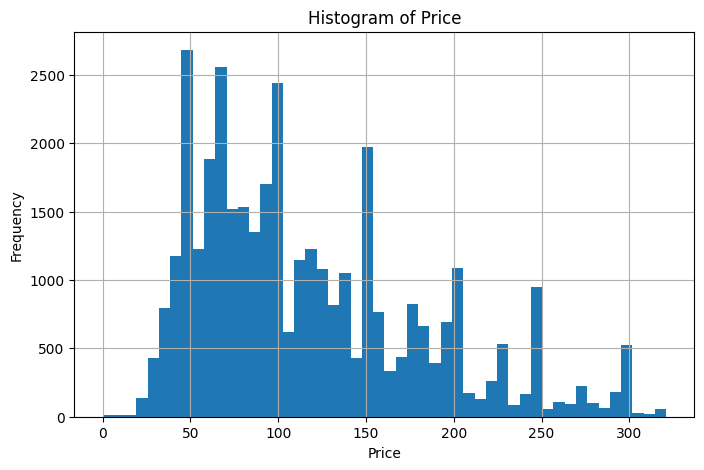

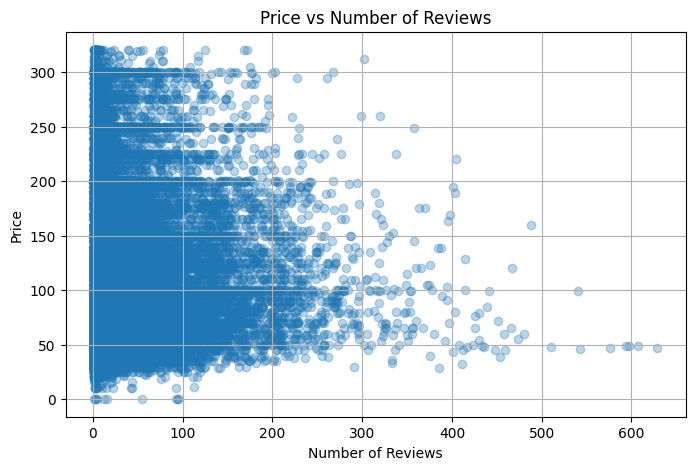

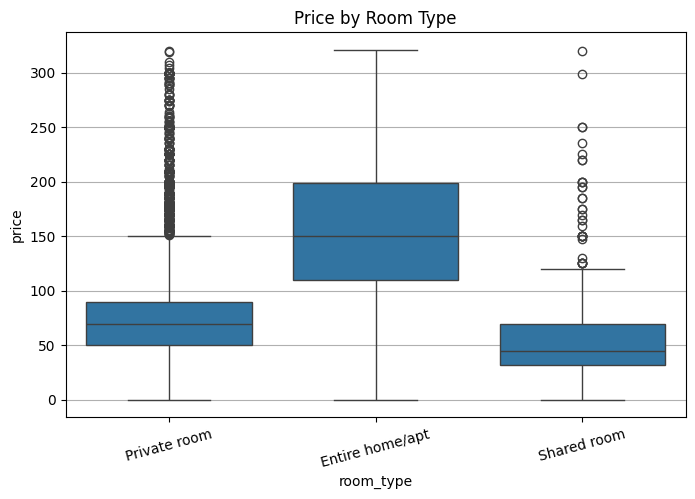

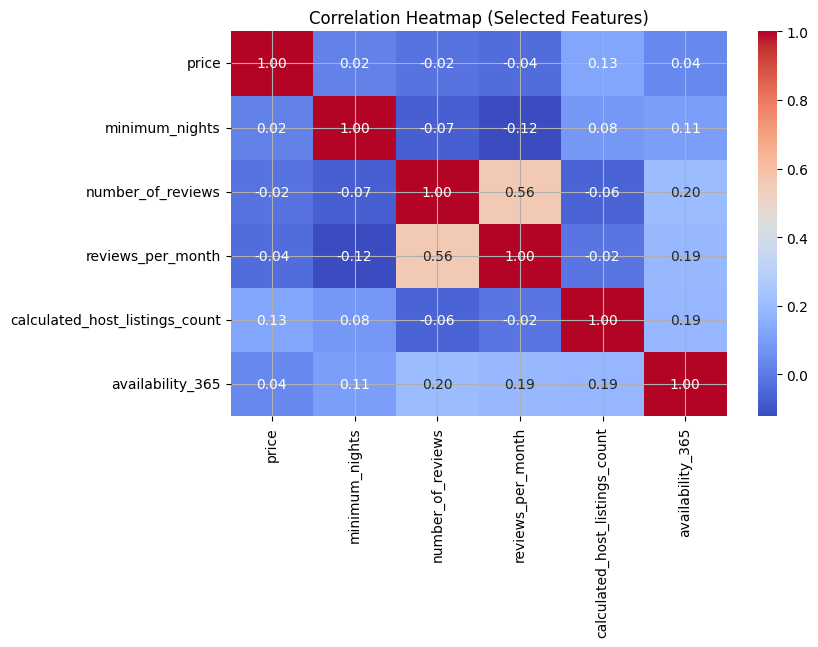

In [20]:

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
desc = df[num_cols].describe().T
display(desc)

#2 Reviews Per Month
if 'reviews_per_month' in df.columns:
    before = len(df)
    df = df.dropna(subset=['reviews_per_month'])
    print(f"Dropped {before - len(df)} rows with missing reviews_per_month.")

if 'last_review' in df.columns:
    df['last_review'] = df['last_review'].astype('string')
    df['last_review'] = df['last_review'].fillna('Unknown')

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

for c in numeric_cols:
    if df[c].isna().any():
        med = df[c].median()
        df[c] = df[c].fillna(med)

for c in categorical_cols:
    if df[c].isna().any():
        mode = df[c].mode(dropna=True)
        fill_val = mode.iloc[0] if len(mode) else "Unknown"
        df[c] = df[c].fillna(fill_val)

#3 Interquartile Range
assert 'price' in df.columns, "Expected a 'price' column in dataset."
Q1, Q3 = df['price'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
before = len(df)
df = df[(df['price'] >= lower) & (df['price'] <= upper)]
print(f"Removed {before - len(df)} outlier rows by price IQR.")

fig, ax = plt.subplots()
ax.hist(df['price'], bins=50)
ax.set_title("Histogram of Price")
ax.set_xlabel("Price")
ax.set_ylabel("Frequency")
plt.show()

# 4) visuals
if 'number_of_reviews' in df.columns:
    fig, ax = plt.subplots()
    ax.scatter(df['number_of_reviews'], df['price'], alpha=0.3)
    ax.set_title("Price vs Number of Reviews")
    ax.set_xlabel("Number of Reviews")
    ax.set_ylabel("Price")
    plt.show()

if 'room_type' in df.columns:
    fig, ax = plt.subplots()
    sns.boxplot(data=df, x='room_type', y='price', ax=ax)
    ax.set_title("Price by Room Type")
    plt.xticks(rotation=15)
    plt.show()

#5) Heatmaps
corr_features = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                 'calculated_host_listings_count', 'availability_365']
existing = [c for c in corr_features if c in df.columns]
corr = df[existing].corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Selected Features)")
plt.show()


## 2) Feature Engineering — 3 pts

In [21]:

# 1 Categorical Variables
cat_features = []
if 'neighbourhood_group' in df.columns:
    cat_features.append('neighbourhood_group')
if 'room_type' in df.columns:
    cat_features.append('room_type')

# 2 price_per_accommodates
df['price_per_accommodates'] = df['price'] / df['minimum_nights'].replace(0, np.nan)
df['price_per_accommodates'] = df['price_per_accommodates'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 3 Numerical features
scale_features = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
                  'calculated_host_listings_count', 'availability_365', 'price_per_accommodates']
scale_features = [f for f in scale_features if f in df.columns]

print("Categorical to encode:", cat_features)
print("Numerical to scale:", scale_features)
df.head()


Categorical to encode: ['neighbourhood_group', 'room_type']
Numerical to scale: ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'price_per_accommodates']


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_per_accommodates
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,149.000000
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,225.000000
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,89.000000
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,8.000000
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,66.666667


## 3) Baseline Regression Models — 2 pts

In [ ]:

# 1 Split the dataset
feature_cols = ['neighbourhood_group', 'room_type', 'minimum_nights', 'number_of_reviews',
                'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
feature_cols = [c for c in feature_cols if c in df.columns]
target_col = 'price'

X = df[feature_cols].copy()
y = df[target_col].copy()

cat_cols = [c for c in feature_cols if c in cat_features]
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocess_baseline = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# 2 Linear Regression Model
baseline_model = Pipeline(steps=[
    ('prep', preprocess_baseline),
    ('lr', LinearRegression())
])

baseline_model.fit(X_train, y_train)

# 3 Evaluation
y_pred = baseline_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)
print(f"Baseline Linear Regression — MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")


Baseline Linear Regression — MSE: 2233.97, RMSE: 47.26, R2: 0.4645


## 4) Lasso, Ridge, and ElasticNet Regression — 2 pts

In [22]:
# 4 Train regression models

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

def RMSE(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

extended_features = feature_cols + ['price_per_accommodates']
extended_features = [f for f in extended_features if f in df.columns]

X_ext = df[extended_features].copy()
y_ext = df[target_col].copy()

cat_cols_ext = [c for c in extended_features if c in cat_features]
num_cols_ext = [c for c in extended_features if c not in cat_cols_ext]

preprocess_scaled = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_ext),
        ('num', StandardScaler(), num_cols_ext)
    ]
)

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_ext, y_ext, test_size=0.2, random_state=RANDOM_STATE
)

param_alpha = [0.01, 0.1, 1, 10, 100]
param_l1 = [0.1, 0.5, 0.9]

def eval_model(name, estimator, param_grid):
    pipe = Pipeline([('prep', preprocess_scaled), ('est', estimator)])
    grid = GridSearchCV(
        pipe,
        param_grid={'est__' + k: v for k, v in param_grid.items()},
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        refit=True
    )
    grid.fit(X_train_e, y_train_e)
    best = grid.best_estimator_
    y_pred = best.predict(X_test_e)
    mse = mean_squared_error(y_test_e, y_pred)
    rmse = RMSE(y_test_e, y_pred)
    r2 = r2_score(y_test_e, y_pred)
    return {
        'model': name,
        'best_params': grid.best_params_,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

results = []
results.append(eval_model('Lasso', Lasso(max_iter=10000), {'alpha': param_alpha}))
results.append(eval_model('Ridge', Ridge(), {'alpha': param_alpha}))
results.append(eval_model('ElasticNet', ElasticNet(max_iter=10000), {'alpha': param_alpha, 'l1_ratio': param_l1}))

pd.DataFrame(results)


,model,best_params,MSE,RMSE,R2
0,Lasso,{'est__alpha': 0.01},1575.179364,39.688529,0.622406
1,Ridge,{'est__alpha': 0.1},1575.251602,39.689439,0.622389
2,ElasticNet,"{'est__alpha': 0.01, 'est__l1_ratio': 0.9}",1574.946213,39.685592,0.622462


## 5) Bias–Variance Tradeoff and Model Complexity — 3 pts

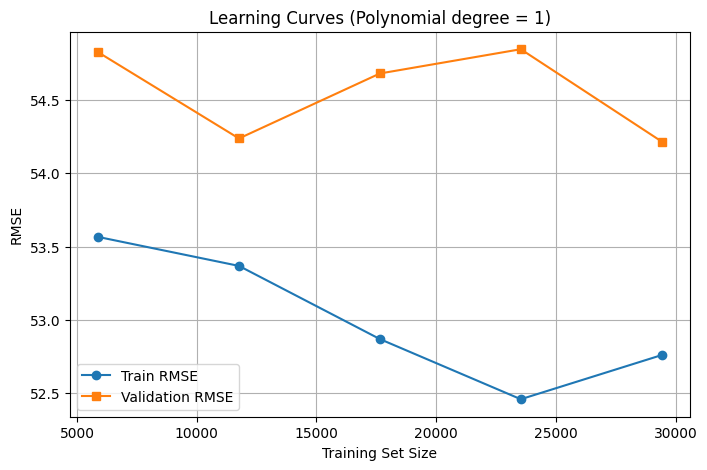

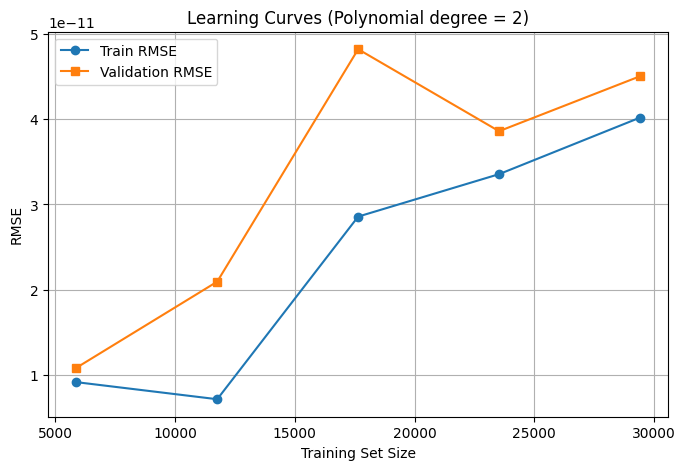

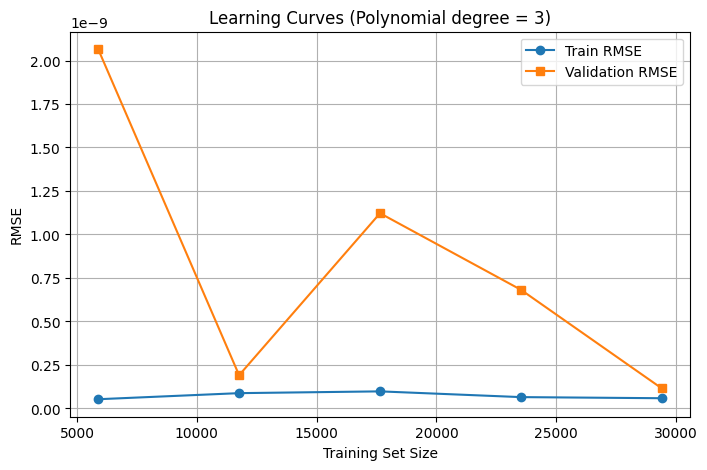

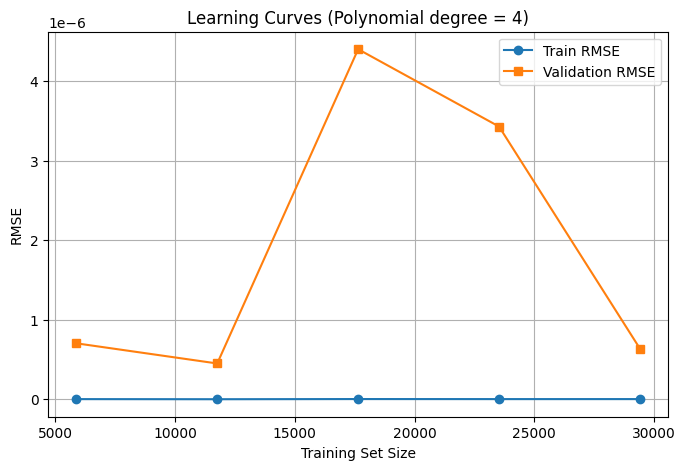

In [ ]:
# 1 Degrees
degrees = [1, 2, 3, 4]

numeric_for_poly = [c for c in ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
                                'calculated_host_listings_count', 'availability_365', 'price_per_accommodates']
                    if c in df.columns]

X_poly = df[numeric_for_poly].copy()
y_poly = df[target_col].copy()

# 2 Learning Curves
def plot_learning_curves(degree):
    poly_pipe = Pipeline([
        ('sc', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('lr', LinearRegression())
    ])
    train_sizes, train_scores, val_scores = learning_curve(
        poly_pipe, X_poly, y_poly, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,
        train_sizes=np.linspace(0.2, 1.0, 5), random_state=RANDOM_STATE
    )
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    val_rmse = np.sqrt(-val_scores.mean(axis=1))

    plt.figure()
    plt.plot(train_sizes, train_rmse, marker='o', label='Train RMSE')
    plt.plot(train_sizes, val_rmse, marker='s', label='Validation RMSE')
    plt.title(f"Learning Curves (Polynomial degree = {degree})")
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

for d in degrees:
    plot_learning_curves(d)



### Discussion (write-up)
- As degree increases, model capacity grows. Low degree (e.g., 1) may show **high bias** (underfitting) with both train and validation errors high and close.  
- Higher degrees can reduce training error but may increase the gap between train and validation curves, indicating **high variance** (overfitting).  
- Choose the degree where validation error is minimized and the gap is reasonable.


## 6) Advanced Visualizations — 2 pts

In [ ]:

# 1 HeaTmaP


assert 'latitude' in df.columns and 'longitude' in df.columns, "Expected 'latitude' and 'longitude' columns."

heat_df = df[['latitude', 'longitude', 'price']].dropna().copy()
w = heat_df['price'].clip(upper=heat_df['price'].quantile(0.95))
w = (w - w.min()) / (w.max() - w.min() + 1e-9)
heat_data = np.column_stack([heat_df['latitude'], heat_df['longitude'], w]).tolist()

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10, tiles='cartodbpositron')
HeatMap(heat_data, radius=10, blur=15, max_zoom=13).add_to(nyc_map)

nyc_map
nyc_map.save("nyc_airbnb_price_heatmap.html")
print("Saved heatmap to nyc_airbnb_price_heatmap.html")


Saved heatmap to nyc_airbnb_price_heatmap.html


Best model by R2: ElasticNet


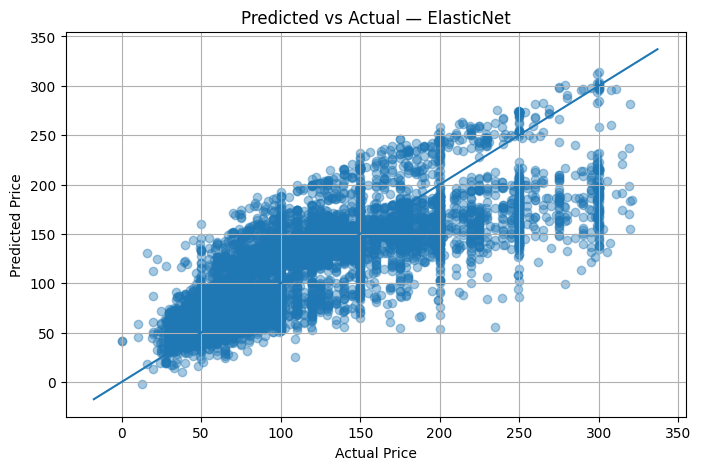

In [ ]:

# 2 Predicted vs Actual

res_df = pd.DataFrame(results)
best_name = res_df.sort_values('R2', ascending=False).iloc[0]['model']
print("Best model by R2:", best_name)

if best_name == 'Lasso':
    est = Lasso(max_iter=10000, random_state=RANDOM_STATE)
    params = {'alpha': [res_df.sort_values('R2', ascending=False).iloc[0]['best_params']['est__alpha']]}
elif best_name == 'Ridge':
    est = Ridge(random_state=RANDOM_STATE)
    params = {'alpha': [res_df.sort_values('R2', ascending=False).iloc[0]['best_params']['est__alpha']]}
else:
    est = ElasticNet(max_iter=10000, random_state=RANDOM_STATE)
    bp = res_df.sort_values('R2', ascending=False).iloc[0]['best_params']
    params = {'alpha': [bp['est__alpha']], 'l1_ratio': [bp['est__l1_ratio']]}

pipe_best = Pipeline([('prep', preprocess_scaled), ('est', est)])
grid_best = GridSearchCV(pipe_best, param_grid={'est__' + k: v for k, v in params.items()}, cv=5, n_jobs=-1, refit=True)
grid_best.fit(X_train_e, y_train_e)
y_pred_best = grid_best.best_estimator_.predict(X_test_e)

plt.figure()
plt.scatter(y_test_e, y_pred_best, alpha=0.4)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Predicted vs Actual — {best_name}")
lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims)
plt.show()
